In [1]:
import pickle
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import class_weight

In [2]:
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate, Input
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
from keras import backend as K
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")

In [4]:
X_train_hist_norm1 =np.load('data/X_train_hist_norm1.npy')
X_valid_hist_norm1 =np.load('data/X_valid_hist_norm1.npy')
X_test_hist_norm1 = np.load('data/X_test_hist_norm1.npy')

In [5]:
y_train_cat =np.load('data/y_train_cat.npy')
y_valid_cat =np.load('data/y_valid_cat.npy')
y_test_cat = np.load('data/y_ttest_cat.npy')

In [6]:
print(X_train_hist_norm1.shape,y_train_cat.shape)
print(X_valid_hist_norm1.shape,y_valid_cat.shape)
print(X_test_hist_norm1.shape,y_test_cat.shape)

(34799, 32, 32, 3) (34799, 43)
(4410, 32, 32, 3) (4410, 43)
(12630, 32, 32, 3) (12630, 43)


In [7]:
datagen = image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.)

In [11]:
def logger(epoch, logs):
    if epoch %1== 0: 
        print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)

In [9]:
def mscn(ksize=(3,3), dropout=0.25): #taking my inspiration from vgg, a deeper network
    input_shape = (32,32,3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1',input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool'))
    
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool'))
    model.add(Flatten())
    
    model1 = Sequential()
    model1.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1b_conv1',input_shape=input_shape))
    model1.add(BatchNormalization())
    model1.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1b_conv2'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1b_pool'))
    model1.add(Flatten())
    
    merged_model = Concatenate([model, model1])
    
    final_model = Sequential()  
#     final_model = model
    final_model.add(merged_model)
#     final_model = merged_model 
    final_model.add(Dense(1024, activation='relu', name='fc1'))
    final_model.add(BatchNormalization())
    final_model.add(Dropout(dropout))
    final_model.add(Dense(512, activation='relu' , name='fc2'))
    final_model.add(BatchNormalization())
    final_model.add(Dropout(dropout))
    final_model.add(Dense(n_classes, activation='softmax', name='final'))
    final_model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    return model

In [10]:
def mscnn(n_classes, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=(32,32,3))
    
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(inputs)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)
    
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)
    
    output1 = Flatten()(block1)
    
    merged = concatenate([output1, output2])
    
    fcblock = Dense(1024, activation='relu', name='fc1')(merged)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)  
    predictions = Dense(n_classes, activation='softmax', name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [12]:
K.clear_session()
batch_size = 32
epochs = 80
model = mscnn(43)

history = model.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/mscnn1.h5', save_best_only=True)
                              ])

0 1.04913247294 0.694703870816 0.931065759637
1 0.232289393753 0.925256472915 0.952834467499
2 0.141471707024 0.955659645392 0.980045351474
3 0.115568136852 0.963303543205 0.892290249433
4 0.0953369877391 0.969050834794 0.981405895881
5 0.0984563633034 0.968591051494 0.985260770975
6 0.0719078023202 0.976982097187 0.95873015873
7 0.0727640746477 0.976349895112 0.980045351474
8 0.059005157096 0.981694876317 0.987074830121
9 0.0607039621258 0.981235092962 0.990476190665
10 0.0594528201306 0.981809822121 0.981859410431
11 0.0562443853423 0.982901807551 0.989115646259
12 0.0460262096743 0.985717980402 0.990476190476
13 0.0482060326721 0.985804189776 0.990022675737
14 0.037505532053 0.988735308486 0.991609977324
15 0.0410484417509 0.987585850168 0.983219954649
16 0.0377454452457 0.988878990776 0.990702947846
17 0.0345963797284 0.98948245642 0.992517006803
18 0.0384916232206 0.987930687663 0.984353741497
19 0.0333292748232 0.98951119285 0.985487528345
20 0.0323871576079 0.989539929336 0.9825

In [15]:
# it's easier to make a multiscale cnn in the functional model in keras, so testing that out here on the 
# vgg like network to make sure it's training properly
def benchmarkModel(n_classes, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=(32,32,3))
    
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(inputs)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)
    
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)
        
    fcblock = Dense(1024, activation='relu', name='fc1')(output2)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)  
    predictions = Dense(n_classes, activation='softmax', name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [ ]:
K.clear_session()
batch_size = 32
epochs = 80
model = benchmarkModel(43)

history = model.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/benchmar-vgglike.h5', save_best_only=True)
                              ])

0 1.0511880395 0.688784160499 0.899546485261


In [6]:
mscnn_model = load_model('models/mscnn1.h5')

In [7]:
# [loss, accuracy] on test set
print(mscnn_model.evaluate(X_test_hist_norm1, y_test_cat, verbose=0))

[0.040500304305114684, 0.98994457648089262]


In [8]:
# [loss, accuracy] on validation set
print(mscnn_model.evaluate(X_valid_hist_norm1, y_valid_cat, verbose=0))

[0.0096135519848739564, 0.99614512471655325]


In [10]:
X_test2_hist = np.load('data/X_test2_hist_normed.npy')
y_test2 = np.load('data/y_test2_cat.npy')

In [11]:
print(mscnn_model.evaluate(X_test2_hist, y_test2, verbose=0))

[1.4146679639816284, 0.75]


In [32]:
test_predict = mscnn_model.predict(X_test2_hist)
top_probas = []
for i in range(len(test_predict)):
    sorted_arr = np.sort(test_predict[i])[::-1]
    sorted_indexes = np.argsort(test_predict[i])[::-1]
    top_probas.append((sorted_indexes[:5], sorted_arr[:5]))

In [33]:
top_probas

[(array([2, 4, 1, 7, 0]),
  array([ 0.9152804 ,  0.06920683,  0.00611995,  0.00439375,  0.00393674], dtype=float32)),
 (array([14, 17,  2,  3,  1]),
  array([  1.00000000e+00,   3.31609371e-08,   7.77006726e-09,
           2.94563196e-09,   9.19399334e-10], dtype=float32)),
 (array([ 0,  4,  8, 26, 25]),
  array([  9.99999523e-01,   3.26843946e-07,   1.50572546e-07,
           1.62073277e-09,   4.08270362e-10], dtype=float32)),
 (array([17,  7,  5,  9,  3]),
  array([  9.90547001e-01,   5.43676876e-03,   1.08420895e-03,
           1.06778578e-03,   3.40334780e-04], dtype=float32)),
 (array([26, 18, 41, 32, 40]),
  array([ 0.35284486,  0.33306062,  0.14714535,  0.05315556,  0.02299345], dtype=float32)),
 (array([2, 3, 5, 1, 7]),
  array([  9.81890202e-01,   1.09547582e-02,   6.95548253e-03,
           5.96393802e-05,   5.55959596e-05], dtype=float32)),
 (array([22, 23,  9,  3, 16]),
  array([  9.99998927e-01,   4.94052870e-07,   3.27922749e-07,
           1.74427072e-07,   1.74506170e-0

In [16]:
# the real classes for the images
test_classes = []
for i in range(len(y_test2)):
    test_classes.append(np.argmax(y_test2[i]))

print(test_classes)

[1, 14, 0, 17, 35, 2, 22, 4]


In [36]:
from scipy.misc import imread, imresize

img1 = imread('data/traffic_sign1.jpg')
img2 = imread('data/traffic_sign14.jpg')
img3 = imread('data/traffic_sign0.jpg')
img4 = imread('data/traffic_sign17.jpg')
img5 = imread('data/traffic_sign35.jpg')
img6 = imread('data/traffic_sign2.jpg')
img7 = imread('data/traffic_sign22.jpg')
img8 = imread('data/traffic_sign4.png')




/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


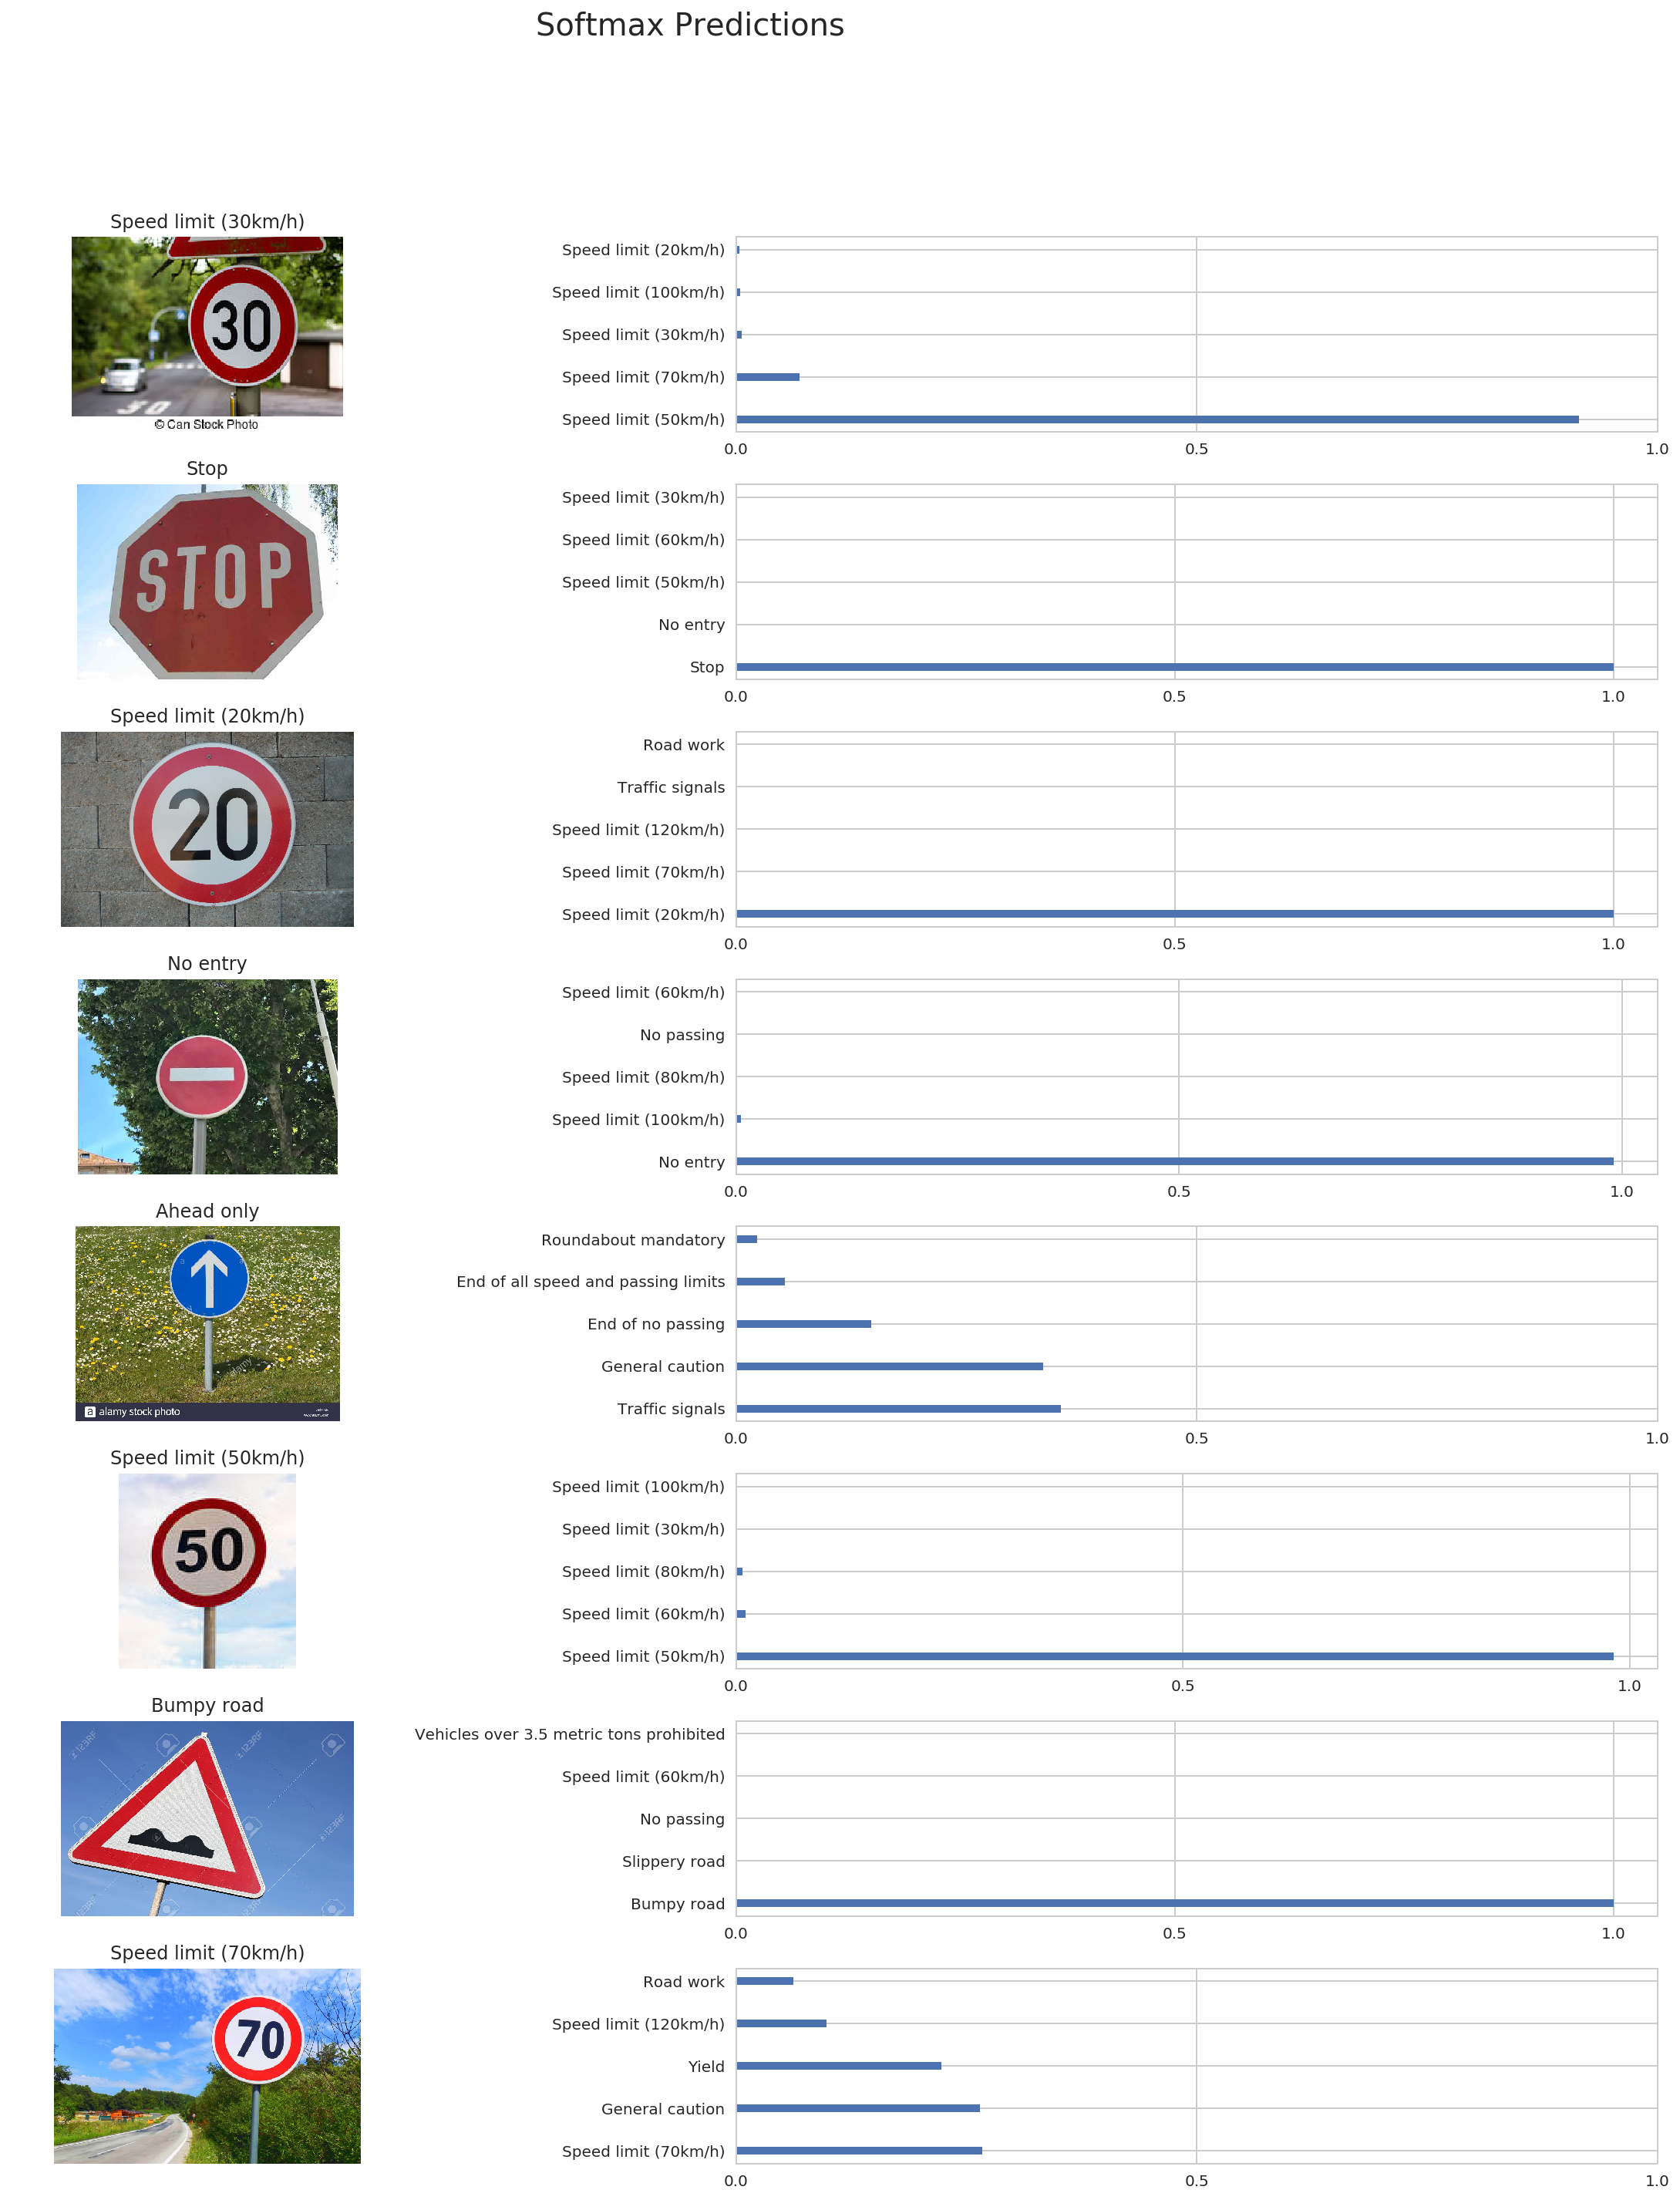

In [48]:
imglist = [img1, img2, img3, img4, img5, img6, img7, img8]
sign_names = pd.read_csv('signnames.csv')['SignName']
n_classes = 43
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(18,18))
fig.tight_layout()
fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)
n_predictions = 5
margin = 0.05
ind = np.arange(n_predictions)
width = (1. - 2. * margin) / n_predictions

for i in range(len(imglist)):
    predictions = top_probas[i]
    pred_labels = predictions[0]
    probs = predictions[1]
    corret_label = sign_names[test_classes[i]]
    pred_labels = [sign_names[pred_i] for pred_i in pred_labels]
    axes[i][0].imshow(imglist[i])
    axes[i][0].set_title(corret_label)
    axes[i][0].set_axis_off()

    axes[i][1].barh(ind + margin, probs, width)
    axes[i][1].set_yticks(ind + margin)
    axes[i][1].set_yticklabels(pred_labels)
    axes[i][1].set_xticks([0, 0.5, 1.0])